# ZNE 

## GHZ State

In [55]:
# Import libraries
import cirq
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the ZNE class
class ZNE:
    def __init__(self, k, fold_type):
        '''
        k: int-> number of folds/repititions.
        fold_type: str-> U U^T U (unitary) or U I I (identity).
        '''
        self.k = k
        self.fold_type = fold_type

    def fold(self, circuit) -> cirq.Circuit:
        '''
        circuit: quantum circuit-> The quantum circuit to perform ZNE on.
        
        returns -> folded circuit based on fold_type.
        '''

        # Initialize new circuit
        folded_circuit = cirq.Circuit()

        if self.fold_type == 'unitary':
            for moment in circuit:
                for op in moment.operations:             
                    folded_circuit.append(op)
                    # Do the k-folding by adding U^t U k times for operation U if U is unitary
                    if cirq.has_unitary(op.gate):
                        folded_circuit += [cirq.inverse(op), op]*self.k
            
            return folded_circuit           
        
        elif self.fold_type == 'identity':
            for moment in circuit:
                for op in moment.operations:      
                    # Apply identity on qubits k times where the operation is applied
                    folded_circuit += [op, cirq.I.on_each(*op.qubits)]*self.k
            return folded_circuit  
        
        else:
            raise ValueError("Invalid fold type. Choose either 'unitary' or 'identity'.")
        

    def extrapolate(self, results, p_degree = 1):
        '''
        results: nparray-> expectation value of a state for different k values.
        p_degree: int-> degree of polynomial to fit.
        
        returns extrapolated value at no noise
        '''

        # Instances from 1 to k
        x = np.arange(1, self.k + 1)

        # Expectation values of a state
        y = np.array(results)

        # Polynomial fit with degree p_degree
        p = np.polyfit(x, y, p_degree)

        # Extrapolated value at x=0
        return np.polyval(p, 0)

# Create a simple circuit with 3 qubits
qubits = [cirq.GridQubit(i, 0) for i in range(3)]
circuit = cirq.Circuit()

# Prepare GHZ state
circuit.append(cirq.H(qubits[0]))
for i in range(2):
    circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))

# Measure all qubits
circuit.append(cirq.measure(*qubits, key='result'))

# Create a noise model
noise = cirq.depolarize(p=0.01)

# Apply noise to the circuit
noisy_circuit = cirq.Circuit(noise.on_each(*circuit.all_qubits()), circuit)

# Run the experiment and collect results
simulator = cirq.Simulator()

n_folds = 3
fit_degree = 1

# Initialize a dictionary to store the results for all states
all_results = {i:[] for i in range(2** len(qubits))}

# Loop over all k values for fit ( until k = 5 in this case)
for k in range(1,n_folds+1):
    # Run ZNE with unitary folding
    zne = ZNE(k, fold_type='unitary')
    folded_circuit = zne.fold(noisy_circuit)
    
    result = simulator.run(folded_circuit, repetitions=1000)
    
    # Calculate the expectation value for each state
    histogram = result.histogram(key='result')
    for state in all_results:
        all_results[state].append(histogram[state]/1000 if state in histogram else 0)

# Fit the results and get the extrapolated value for each state
extrapolated_values = {}
for state, results in all_results.items():
    extrapolated_values[state] = min(zne.extrapolate(results,fit_degree),1)

# Run the experiment with a noise-free simulator
noise_free_simulator = cirq.Simulator()
noise_free_results = {i: 0 for i in range(2**len(qubits))}

# Run the noise free simulator
result = noise_free_simulator.run(circuit, repetitions=1000)
    
# Calculate the expectation value of getting 0 on all 3 qubits
histogram = result.histogram(key='result')
for state in all_results:
    noise_free_results[state]= histogram[state]/1000 if state in histogram else 0

# Multiply the values by the number of shots
extrapolated_values = {state: value * 1000 for state, value in extrapolated_values.items()}
noise_free_results = {state: value * 1000 for state, value in noise_free_results.items()}

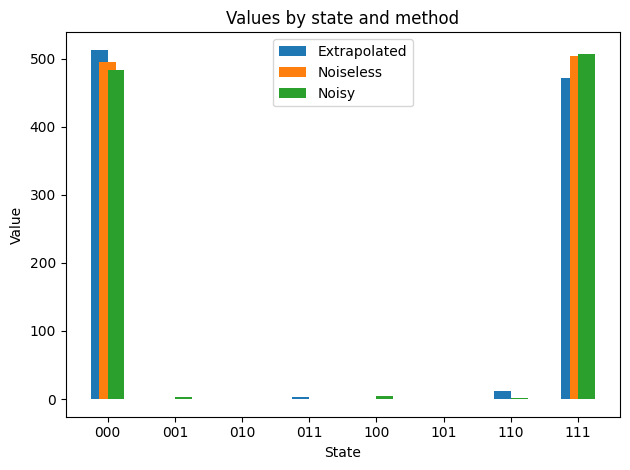

In [56]:
# Create side-by-side histograms of the extrapolated values and the noiseless values
labels = [format(i, '03b') for i in extrapolated_values.keys()]
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(extrapolated_values.values()), width, label='Extrapolated')
rects2 = ax.bar(x, list(noise_free_results.values()), width, label='Noiseless')
rects3 = ax.bar(x + width/2, [1000*v[-1] for v in all_results.values()], width, label = 'Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('State')
ax.set_ylabel('Value')
ax.set_title('Values by state and method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

## Random State

### Unitary fold

In [57]:
# Import libraries
import cirq
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the ZNE class
class ZNE:
    def __init__(self, k, fold_type):
        '''
        k: int-> number of folds/repititions.
        fold_type: str-> U U^T U (unitary) or U I I (identity).
        '''
        self.k = k
        self.fold_type = fold_type

    def fold(self, circuit) -> cirq.Circuit:
        '''
        circuit: quantum circuit-> The quantum circuit to perform ZNE on.
        
        returns -> folded circuit based on fold_type.
        '''

        # Initialize new circuit
        folded_circuit = cirq.Circuit()

        if self.fold_type == 'unitary':
            for moment in circuit:
                for op in moment.operations:             
                    folded_circuit.append(op)
                    # Do the k-folding by adding U^t U k times for operation U if U is unitary
                    if cirq.has_unitary(op.gate):
                        folded_circuit += [cirq.inverse(op), op]*self.k
            
            return folded_circuit           
        
        elif self.fold_type == 'identity':
            for moment in circuit:
                for op in moment.operations:      
                    # Apply identity on qubits k times where the operation is applied
                    folded_circuit += [op, cirq.I.on_each(*op.qubits)]*self.k
            return folded_circuit  
        
        else:
            raise ValueError("Invalid fold type. Choose either 'unitary' or 'identity'.")
        

    def extrapolate(self, results, p_degree = 1):
        '''
        results: nparray-> expectation value of a state for different k values.
        p_degree: int-> degree of polynomial to fit.
        
        returns extrapolated value at no noise
        '''

        # Instances from 1 to k
        x = np.arange(1, self.k + 1)

        # Expectation values of a state
        y = np.array(results)

        # Polynomial fit with degree p_degree
        p = np.polyfit(x, y, p_degree)

        # Extrapolated value at x=0
        return np.polyval(p, 0)

# Create a simple circuit with 3 qubits
qubits = [cirq.GridQubit(i, 0) for i in range(3)]
circuit = cirq.Circuit()

# Prepare any state
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.X(qubits[1]))
circuit.append(cirq.X(qubits[2]))
circuit.append(cirq.CNOT(qubits[0],qubits[2]))
circuit.append(cirq.H(qubits[1]))

# Measure all qubits
circuit.append(cirq.measure(*qubits, key='result'))

# Create a noise model
noise = cirq.depolarize(p=0.1)

# Apply noise to the circuit
noisy_circuit = cirq.Circuit(noise.on_each(*circuit.all_qubits()), circuit)

# Run the experiment and collect results
simulator = cirq.Simulator()

n_folds = 4
fit_degree = 1

# Initialize a dictionary to store the results for all states
all_results = {i:[] for i in range(2** len(qubits))}

# Loop over all k values for fit ( until k = 5 in this case)
for k in range(1,n_folds+1):
    # Run ZNE with unitary folding
    zne = ZNE(k, fold_type='unitary')
    folded_circuit = zne.fold(noisy_circuit)
    
    result = simulator.run(folded_circuit, repetitions=1000)
    
    # Calculate the expectation value for each state
    histogram = result.histogram(key='result')
    for state in all_results:
        all_results[state].append(histogram[state]/1000 if state in histogram else 0)

# Fit the results and get the extrapolated value for each state
extrapolated_values = {}
for state, results in all_results.items():
    extrapolated_values[state] = min(zne.extrapolate(results,fit_degree),1)

# Run the experiment with a noise-free simulator
noise_free_simulator = cirq.Simulator()
noise_free_results = {i: 0 for i in range(2**len(qubits))}

# Run the noise free simulator
result = noise_free_simulator.run(circuit, repetitions=1000)
    
# Calculate the expectation value of getting 0 on all 3 qubits
histogram = result.histogram(key='result')
for state in all_results:
    noise_free_results[state]= histogram[state]/1000 if state in histogram else 0

# Multiply the values by the number of shots
extrapolated_values = {state: value * 1000 for state, value in extrapolated_values.items()}
noise_free_results = {state: value * 1000 for state, value in noise_free_results.items()}

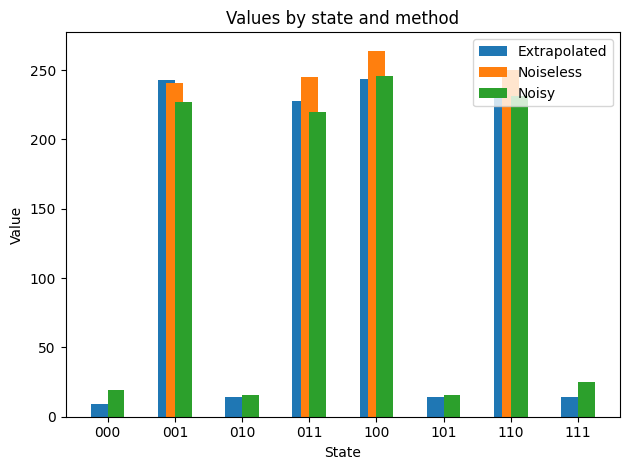

In [58]:
# Create side-by-side histograms of the extrapolated values and the noiseless values
labels = [format(i, '03b') for i in extrapolated_values.keys()]
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(extrapolated_values.values()), width, label='Extrapolated')
rects2 = ax.bar(x, list(noise_free_results.values()), width, label='Noiseless')
rects3 = ax.bar(x + width/2, [1000*v[-1] for v in all_results.values()], width, label = 'Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('State')
ax.set_ylabel('Value')
ax.set_title('Values by state and method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

### Identity fold

In [61]:
# Import libraries
import cirq
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the ZNE class
class ZNE:
    def __init__(self, k, fold_type):
        '''
        k: int-> number of folds/repititions.
        fold_type: str-> U U^T U (unitary) or U I I (identity).
        '''
        self.k = k
        self.fold_type = fold_type

    def fold(self, circuit) -> cirq.Circuit:
        '''
        circuit: quantum circuit-> The quantum circuit to perform ZNE on.
        
        returns -> folded circuit based on fold_type.
        '''

        # Initialize new circuit
        folded_circuit = cirq.Circuit()

        if self.fold_type == 'unitary':
            for moment in circuit:
                for op in moment.operations:             
                    folded_circuit.append(op)
                    # Do the k-folding by adding U^t U k times for operation U if U is unitary
                    if cirq.has_unitary(op.gate):
                        folded_circuit += [cirq.inverse(op), op]*self.k
            
            return folded_circuit           
        
        elif self.fold_type == 'identity':
            for moment in circuit:
                for op in moment.operations: 
                    folded_circuit.append(op)
                    # Apply identity on qubits k times where the operation is applied
                    folded_circuit += [cirq.I.on_each(*op.qubits)]*self.k
            
            return folded_circuit  
        
        else:
            raise ValueError("Invalid fold type. Choose either 'unitary' or 'identity'.")
        

    def extrapolate(self, results, p_degree = 1):
        '''
        results: nparray-> expectation value of a state for different k values.
        p_degree: int-> degree of polynomial to fit.
        
        returns extrapolated value at no noise
        '''

        # Instances from 1 to k
        x = np.arange(1, self.k + 1)

        # Expectation values of a state
        y = np.array(results)

        # Polynomial fit with degree p_degree
        p = np.polyfit(x, y, p_degree)

        # Extrapolated value at x=0
        return np.polyval(p, 0)

# Create a simple circuit with 3 qubits
qubits = [cirq.GridQubit(i, 0) for i in range(3)]
circuit = cirq.Circuit()

# Prepare any state
circuit.append(cirq.H(qubits[0]))
circuit.append(cirq.X(qubits[1]))
circuit.append(cirq.X(qubits[2]))
circuit.append(cirq.CNOT(qubits[0],qubits[2]))
circuit.append(cirq.H(qubits[1]))

# Measure all qubits
circuit.append(cirq.measure(*qubits, key='result'))

# Create a noise model
noise = cirq.depolarize(p=0.1)

# Apply noise to the circuit
noisy_circuit = cirq.Circuit(noise.on_each(*circuit.all_qubits()), circuit)

# Run the experiment and collect results
simulator = cirq.Simulator()

n_folds = 4
fit_degree = 1

# Initialize a dictionary to store the results for all states
all_results = {i:[] for i in range(2** len(qubits))}

# Loop over all k values for fit ( until k = 5 in this case)
for k in range(1,n_folds+1):
    # Run ZNE with unitary folding
    zne = ZNE(k, fold_type='identity')
    folded_circuit = zne.fold(noisy_circuit)
    
    result = simulator.run(folded_circuit, repetitions=1000)
    
    # Calculate the expectation value for each state
    histogram = result.histogram(key='result')
    for state in all_results:
        all_results[state].append(histogram[state]/1000 if state in histogram else 0)

# Fit the results and get the extrapolated value for each state
extrapolated_values = {}
for state, results in all_results.items():
    extrapolated_values[state] = min(zne.extrapolate(results,fit_degree),1)

# Run the experiment with a noise-free simulator
noise_free_simulator = cirq.Simulator()
noise_free_results = {i: 0 for i in range(2**len(qubits))}

# Run the noise free simulator
result = noise_free_simulator.run(circuit, repetitions=1000)
    
# Calculate the expectation value of getting 0 on all 3 qubits
histogram = result.histogram(key='result')
for state in all_results:
    noise_free_results[state]= histogram[state]/1000 if state in histogram else 0

# Multiply the values by the number of shots
extrapolated_values = {state: value * 1000 for state, value in extrapolated_values.items()}
noise_free_results = {state: value * 1000 for state, value in noise_free_results.items()}

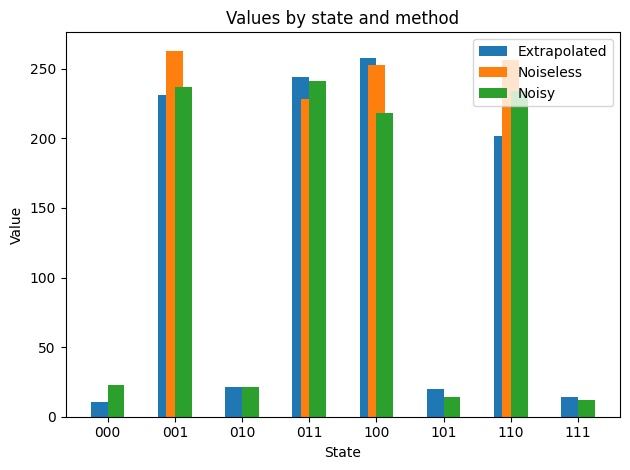

In [62]:
# Create side-by-side histograms of the extrapolated values and the noiseless values
labels = [format(i, '03b') for i in extrapolated_values.keys()]
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, list(extrapolated_values.values()), width, label='Extrapolated')
rects2 = ax.bar(x, list(noise_free_results.values()), width, label='Noiseless')
rects3 = ax.bar(x + width/2, [1000*v[-1] for v in all_results.values()], width, label = 'Noisy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('State')
ax.set_ylabel('Value')
ax.set_title('Values by state and method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()